# KL2 Data Processing

In [64]:
%load_ext autoreload
%autoreload 2

## 1 Relabeling

### 1.1 Features Renaming & Preliminary Relabeling

The folder "Data Preprocessing" defines some rules to rename features as well as some preliminary relabeling of feature values.

This section load these rules and process the data as a first step.

In [90]:
# libraries, utility functions

import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

def load_lookup_table(folder_path):
    '''
    "Data Preprocessing" folder contains a bunch of .xlsx's, each coming with one or multiple sheets.
    Each sheet is expected to have only 2 column.
    The first row is a mapping from original column name in collected data, to a more refined (?) variation.
    The rest of the rows are a mapping from field values on the questionnaire to an interpretable label, usually a string.
    If for some row there's no value at the second column, that means we are not interested in those feature values.
    '''
    column_map = {}
    lookup_table = {'columns': column_map} # `column_map`: map old column in original

    excel_paths = glob(os.path.join(folder_path, "*.xlsx"))
    for path in excel_paths:    # read each excel files
        xls = pd.ExcelFile(path)
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(path, sheet_name=sheet_name, header=None)    # one df per sheet
            if df.shape[1] >= 2:  # ensure at least two columns exist
                old_col_name, new_col_name = df.iloc[0, :2].str.strip()
                if pd.isna(old_col_name):
                    continue
                if pd.isna(new_col_name):
                    new_col_name = old_col_name
                column_map[old_col_name] = new_col_name
                relabel_map = dict(df.iloc[1:, :2].itertuples(index=False))
                lookup_table[new_col_name] = relabel_map
    # more: add two new feature names: 'diagnosis_b' and 'diagnosis_c'
    lookup_table['columns']['diagnosisb'] = 'diagnosis_b'
    lookup_table['columns']['diagnosisc'] = 'diagnosis_c'
    # set the mapping to the same as 'diagnosis'
    lookup_table['diagnosis_b'] = lookup_table['diagnosis']
    lookup_table['diagnosis_c'] = lookup_table['diagnosis']

    # load diagnosis to stroke type csv and add that mapping
    diagnosis_to_stroke_type = pd.read_csv(glob(os.path.join(folder_path, "*.csv"))[0], low_memory=False).set_index('Code')['Stroke type'].to_dict()
    # print(diagnosis_to_stroke_type)
    lookup_table['columns']['diagnosis'] = 'stroke_type'
    lookup_table['stroke_type'] = diagnosis_to_stroke_type
    return lookup_table

def format_data(raw_data_path, lookup_table, keep_columns=True):
    df = pd.read_csv(raw_data_path, delimiter='|', low_memory=False)[:-1] # drop last row: summarizing # rows of the table
    df.iloc[:, 0] = df.iloc[:, 0].astype(float) # first column is coerced to int due to error caused by last special row 
    df.rename(columns=lookup_table['columns'], inplace=True)
    df.replace(lookup_table, inplace=True)
    if not keep_columns:
        columns = df.columns.intersection(lookup_table['columns'].values())
        df = df[columns]

    return df

# # Usage
# folder_path = "../data/Data Preprocessing/"
# raw_data_path = '../data/Original files/Cogan_eRD_RIC1_request.txt'  # Update this to your raw data file path
# output_path = '/path/to/output/renamed_data.xlsx'  # Update this to your desired output file path

# data_dict = load_data_dictionary(folder_path)
# relabeled_data = rename_columns(raw_data_path, data_dict, keep_columns=True)  # Set keep_columns to False if you want to drop columns not in the data dictionary

In [91]:
# load folder "Data Preprocessing" as a lookup table

folder_path = "./data/Data Preprocessing/"
raw_data_path = './data/Original files/Cogan_eRD_RIC1_request.txt'
lookup_table = load_lookup_table(folder_path)

print(lookup_table['columns'])
print(lookup_table['diagnosis'])

{'diagnosis': 'stroke_type', 'priorselfcare': 'selfcare_prior', 'priorindoormobility': 'mobility_prior', 'priorstairs': 'stairs_prior', 'priorfunctionalcognition': 'func_cog_prior', 'pdumanualwheelchair': 'wc_manual_prior', 'pdumotorizedwheelchair': 'wc_motor_prior', 'pdumechanicallift': 'mechlift_prior', 'pduwalker': 'walker_prior', 'pduorthoticsprosthetics': 'orth_pros_prior', 'pdunone': 'no_device_prior', 'eatingadm': 'eating_adm', 'eatinggoal': 'eating_goal', 'oralhygieneadm': 'oral_adm', 'oralhygienegoal': 'oral_goal', 'toiletinghygieneadm': 'toileting_adm', 'toiletinghygienegoal': 'toileting_goal', 'showerbatheadm': 'bathe_adm', 'showerbathegoal': 'bathe_goal', 'dressupperbodyadm': 'dress_upper_adm', 'dressupperbodygoal': 'dress_upper_goal', 'dresslowerbodyadm': 'dress_lower_adm', 'dresslowerbodygoal': 'dress_lower_goal', 'dondofffootwearadm': 'footwear_adm', 'dondofffootweargoal': 'footwear_goal', 'rollleftrightadm': 'roll_lr_adm', 'rollleftrightgoal': 'roll_lr_goal', 'sittolyin

In [92]:
# preprocess data with lookup table

df = format_data(raw_data_path, lookup_table, keep_columns=True)

df

,sex,marital_status,admityear,admitclass,admit_from,prehospital_living,prehospital_living_with,payor_primary,payor_secondary,impgroupadmit,...,los,ric,cmg,tier,shortstayexpired,shortstaycmg,transferpatient,incompletestay,unplanned_discharge,id
0,female,Married,2023.0,1.0,Short-term general hospital,Home,Family,Medicare FFS,Not listed,1.2,...,21.0,1.0,104.0,3.0,NaN,NaN,f,f,NaN,1.0
1,male,Married,2023.0,1.0,Short-term general hospital,Home,Family,Medicare Advantage,Not listed,1.2,...,14.0,1.0,102.0,NaN,NaN,NaN,f,f,NaN,2.0
2,male,Married,2023.0,1.0,Short-term general hospital,Home,Family,Medicare Advantage,Not listed,1.2,...,5.0,1.0,103.0,NaN,NaN,NaN,f,f,NaN,3.0
3,female,Widowed,2022.0,1.0,Short-term general hospital,Home,Family,Medicare FFS,Not listed,1.1,...,9.0,1.0,102.0,NaN,NaN,NaN,f,f,NaN,4.0
4,female,NaN,2023.0,1.0,Short-term general hospital,Home,Alone,Not listed,Not listed,1.3,...,22.0,1.0,106.0,3.0,f,NaN,t,f,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43740,female,Widowed,2022.0,1.0,Short-term general hospital,Home,Family,Medicare FFS,Not listed,1.3,...,17.0,1.0,104.0,3.0,NaN,NaN,f,f,NaN,43741.0
43741,female,Never married,2022.0,NaN,Long-term care hospital,Home,Alone,Medicare FFS,Not listed,1.1,...,7.0,1.0,106.0,NaN,f,NaN,t,t,NaN,43742.0
43742,female,Married,2022.0,1.0,Short-term general hospital,Home,Attendant,Medicare FFS,Not listed,1.2,...,29.0,1.0,106.0,NaN,NaN,NaN,f,f,NaN,43743.0
43743,male,Married,2022.0,1.0,Short-term general hospital,Home,Family,Medicare Advantage,Not listed,1.1,...,16.0,1.0,106.0,NaN,f,NaN,t,f,NaN,43744.0


In [93]:
# have a look at unique diagnosis
# currently, we get rid of diagnosis descriptions, but use grouped stroke types

# print("# of unique diagnosis:", df['diagnosis'].unique().size)
# df['diagnosis'].unique()

print("# of unique stroke types:", df['stroke_type'].unique().size)
df['stroke_type'].unique()

# of unique stroke types: 3


array(['Ischemic', 'Hemorrhagic', 'Other'], dtype=object)

In [94]:
# save preprocessed data

df.to_csv('./data/Cleaned files/Cogan_1_1.csv', index=False)

In [95]:
# save lookup table
import pickle

with open("./data/Cleaned files/lookup_table.pkl", 'wb') as f:
    pickle.dump(lookup_table, f)

#### Examine some features of interest here

In [96]:
lookup_table['language']

{nan: nan}

### 1.2 Add Aggregated Outcomes 

In [97]:
# load formated dataframe and see all feature names

import pandas as pd
import pickle
from tabulate import tabulate
import numpy as np

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_1.csv', low_memory=False)
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)

feature_names = [*df.head()]
print("total # of features:", len(feature_names))

print(tabulate(enumerate(feature_names), headers=["Index", "Name"], tablefmt="grid"))

total # of features: 449
+---------+--------------------------------+
|   Index | Name                           |
+=========+================================+
|       0 | sex                            |
+---------+--------------------------------+
|       1 | marital_status                 |
+---------+--------------------------------+
|       2 | admityear                      |
+---------+--------------------------------+
|       3 | admitclass                     |
+---------+--------------------------------+
|       4 | admit_from                     |
+---------+--------------------------------+
|       5 | prehospital_living             |
+---------+--------------------------------+
|       6 | prehospital_living_with        |
+---------+--------------------------------+
|       7 | payor_primary                  |
+---------+--------------------------------+
|       8 | payor_secondary                |
+---------+--------------------------------+
|       9 | impgroupadmit     

In [98]:
# define outcome features
selfcare_items = [
    "eating",
    "oral",
    "toileting",
    "bathe",
    "dress_upper",
    "dress_lower",
    "footwear",
]
mobility_items = [
    "roll_lr",
    "sit_lying",
    "lying_sit",
    "sit_stand",
    "bed_chair",
    "toilet_trans",
    "car_trans",
    "walk10ft",
    "walk50ft",
    "walk150ft",
    "walk10ft_uneven",
    "walk1step",
    "walk4step",
    "walk12step",
    "pickup"
]
print("# of selfcare items:", len(selfcare_items))
print("# of mobility items:", len(mobility_items))

# of selfcare items: 7
# of mobility items: 15


In [99]:
# define ordinal sum to measure mapping
selfcare_table = {
    7: 19.65,
    8: 24.7,
    9: 27.64,
    10: 29.69,
    11: 31.44,
    12: 33.02,
    13: 34.46,
    14: 35.78,
    15: 36.97,
    16: 38.04,
    17: 38.98,
    18: 39.84,
    19: 40.62,
    20: 41.35,
    21: 42.05,
    22: 42.73,
    23: 43.39,
    24: 44.07,
    25: 44.77,
    26: 45.52,
    27: 46.33,
    28: 47.25,
    29: 48.33,
    30: 49.64,
    31: 51.28,
    32: 53.37,
    33: 56.1,
    34: 59.86,
    35: 65.47,
    36: 71.86,
    37: 76.96,
    38: 81.08,
    39: 84.76,
    40: 88.57,
    41: 93.54,
    42: 100.64,
}
mobility_table = {
    15: 4.86,
    16: 11.07,
    17: 14.3,
    18: 16.1,
    19: 17.35,
    20: 18.34,
    21: 19.16,
    22: 19.89,
    23: 20.54,
    24: 21.14,
    25: 21.71,
    26: 22.26,
    27: 22.79,
    28: 23.3,
    29: 23.81,
    30: 24.31,
    31: 24.81,
    32: 25.31,
    33: 25.82,
    34: 26.32,
    35: 26.82,
    36: 27.32,
    37: 27.83,
    38: 28.33,
    39: 28.82,
    40: 29.32,
    41: 29.81,
    42: 30.29,
    43: 30.77,
    44: 31.25,
    45: 31.72,
    46: 32.18,
    47: 32.65,
    48: 33.11,
    49: 33.57,
    50: 34.02,
    51: 34.48,
    52: 34.93,
    53: 35.39,
    54: 35.85,
    55: 36.32,
    56: 36.88,
    57: 37.28,
    58: 37.77,
    59: 38.28,
    60: 38.81,
    61: 39.36,
    62: 39.94,
    63: 40.56,
    64: 41.21,
    65: 41.92,
    66: 42.68,
    67: 43.52,
    68: 44.46,
    69: 45.53,
    70: 46.75,
    71: 48.17,
    72: 49.83,
    73: 51.76,
    74: 53.98,
    75: 56.42,
    76: 58.93,
    77: 61.36,
    78: 63.64,
    79: 65.73,
    80: 67.83,
    81: 69.82,
    82: 71.78,
    83: 73.76,
    84: 75.79,
    85: 77.91,
    86: 80.21,
    87: 82.62,
    88: 86.36,
    89: 90.90,
    90: 98.38
}


In [100]:
# safe buffer
last_df = df

In [101]:
# for outcome features, replace invalid responses as nan and count invalid samples
df = last_df.copy()
selfcare_columns = [item + '_adm' for item in selfcare_items] + [item + '_dc' for item in selfcare_items]
mobility_columns = [item + '_adm' for item in mobility_items] + [item + '_dc' for item in mobility_items]

subset_columns = [item + '_adm' for item in selfcare_items+mobility_items]
subset_columns += [item + '_dc' for item in selfcare_items+mobility_items]
df.loc[:, subset_columns] = df.loc[:, subset_columns].replace({
    'Refused': np.nan,
    'Not_applicable': np.nan,
    'Not_attempted': np.nan,
    'Safety': np.nan
})
print(df[subset_columns].isna().sum(axis=0))
# df = df.dropna(subset=selfcare_columns)
# df = df.dropna(subset=subset_columns)
# print("# of valid patients changed from", len(last_df), "to", len(df))

eating_adm              2474
oral_adm                1387
toileting_adm            984
bathe_adm               4420
dress_upper_adm         1750
dress_lower_adm         1343
footwear_adm             958
roll_lr_adm             1229
sit_lying_adm           1430
lying_sit_adm           1433
sit_stand_adm           3711
bed_chair_adm           2403
toilet_trans_adm        5618
car_trans_adm          24704
walk10ft_adm           15365
walk50ft_adm           24103
walk150ft_adm          32291
walk10ft_uneven_adm    31558
walk1step_adm          25778
walk4step_adm          29097
walk12step_adm         37282
pickup_adm             29537
eating_dc               3732
oral_dc                 3152
toileting_dc            3077
bathe_dc                3336
dress_upper_dc          3124
dress_lower_dc          3099
footwear_dc             3135
roll_lr_dc              3199
sit_lying_dc            3145
lying_sit_dc            3142
sit_stand_dc            3553
bed_chair_dc            3125
toilet_trans_d

In [102]:
# calculate 4 measures

DO_IMPUTE_MISSING_OUTCOMES = True

if DO_IMPUTE_MISSING_OUTCOMES:
    df.loc[:, subset_columns] = df.loc[:, subset_columns].fillna(1) # replace NaNs with 1 ordinal

inverse_lookup = {v:k for k,v in lookup_table[selfcare_items[0]+'_adm'].items()}
print(inverse_lookup)

selfcare_sum_adm = df[[item + '_adm' for item in selfcare_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
# print(selfcare_sum_adm[:10])
selfcare_sum_dc = df[[item + '_dc' for item in selfcare_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
print("selfcare sum adm nan count:", np.sum(np.isnan(selfcare_sum_adm)))
print("selfcare sum dc nan count:", np.sum(np.isnan(selfcare_sum_dc)))

selfcare_measure_adm = selfcare_sum_adm.map(selfcare_table)
# print(selfcare_measure_adm[:10])
selfcare_measure_dc = selfcare_sum_dc.map(selfcare_table)
print("selfcare measure adm nan count:", np.sum(pd.isna(selfcare_measure_adm).to_numpy()))
print("selfcare measure dc nan count:", np.sum(pd.isna(selfcare_measure_dc).to_numpy()))

mobility_sum_adm = df[[item + '_adm' for item in mobility_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
mobility_sum_dc = df[[item + '_dc' for item in mobility_items]].replace(inverse_lookup).sum(axis=1, skipna=False)
print("mobility sum adm nan count:", np.sum(np.isnan(mobility_sum_adm)))
print("mobility sum dc nan count:", np.sum(np.isnan(mobility_sum_dc)))
mobility_measure_adm = mobility_sum_adm.map(mobility_table)
mobility_measure_dc = mobility_sum_dc.map(mobility_table)
print("mobility measure adm nan count:", np.sum(pd.isna(mobility_measure_adm).to_numpy()))
print("mobility measure dc nan count:", np.sum(pd.isna(mobility_measure_dc).to_numpy()))

{'Independent': 6, 'Setup': 5, 'Supervised': 4, 'Mod_assist': 3, 'Max_assist': 2, 'Dependent': 1, 'Refused': 7, 'Not_applicable': 9, 'Not_attempted': 10, 'Safety': 88}
selfcare sum adm nan count: 0
selfcare sum dc nan count: 0
selfcare measure adm nan count: 0
selfcare measure dc nan count: 0
mobility sum adm nan count: 0
mobility sum dc nan count: 0
mobility measure adm nan count: 0
mobility measure dc nan count: 0


In [103]:
# add outcome measure columns to the df
df['selfcare_measure_adm'] = selfcare_measure_adm
df['selfcare_measure_dc'] = selfcare_measure_dc
df['mobility_measure_adm'] = mobility_measure_adm
df['mobility_measure_dc'] = mobility_measure_dc

# add two delta measure columns, just for quick filtering out valid samples (measures @adm&dc are both valid)
df['selfcare_measure_delta'] = (selfcare_measure_dc - selfcare_measure_adm).round(2)
df['mobility_measure_delta'] = (mobility_measure_dc - mobility_measure_adm).round(2)
print("# of invalid samples for selfcare:", np.isnan(df['selfcare_measure_delta']).sum(), " out of", len(df))
print("# of invalid samples for mobility:", np.isnan(df['mobility_measure_delta']).sum(), " out of", len(df))

# of invalid samples for selfcare: 0  out of 43745
# of invalid samples for mobility: 0  out of 43745


In [104]:
print(min(df['selfcare_measure_dc']))

19.65


In [105]:
# save processed data with 6 extra columns

df.to_csv('./data/Cleaned files/Cogan_1_2.csv', index=False)

### 1.3 Relabel & Process Features


In [1]:
# total # of features and a list of all feature names

CLINICALLY_MEANINGFUL = True # if true, some ranked int feature values will be combined into clinically meaningful groups, with several fixed cutting points

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_2.csv', low_memory=False)
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))
categorical_feature_set = set()
numeric_feature_set = set()
ranked_int_feature_set = set()
binary_feature_set = set()

total # of features: 455
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | float64 |
+---------+--------------------------------+---------+
|       3 | admitclass                     | float64 |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

In [2]:
# set column 'id' as index
df['id'] = df['id'].astype(int)

df.set_index('id', inplace=True)
print(df)

          sex marital_status  admityear  admitclass  \
id                                                    
1      female        Married     2023.0         1.0   
2        male        Married     2023.0         1.0   
3        male        Married     2023.0         1.0   
4      female        Widowed     2022.0         1.0   
5      female            NaN     2023.0         1.0   
...       ...            ...        ...         ...   
43741  female        Widowed     2022.0         1.0   
43742  female  Never married     2022.0         NaN   
43743  female        Married     2022.0         1.0   
43744    male        Married     2022.0         1.0   
43745  female        Widowed     2023.0         1.0   

                        admit_from prehospital_living prehospital_living_with  \
id                                                                              
1      Short-term general hospital               Home                  Family   
2      Short-term general hospital       

#### Column: "maritalstatus"

In [3]:
# safe buffer
last_df = df

In [4]:
# process column "marital status": (currently) Married or Unmarried
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["marital_status"].unique())
df["marital_status"] = df["marital_status"].replace(['Widowed', 'Divorced', 'Separated', 'Never married'], 'Unmarried')
print(df["marital_status"].unique())

['Married' 'Widowed' nan 'Divorced' 'Separated' 'Never married']
['Married' 'Unmarried' nan]


#### Column: "admitclass"

In [5]:
# safe buffer
last_df = df

In [6]:
# process column "admitclass"
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["admitclass"].unique())
df['admitclass'] = df['admitclass'].astype('Int32')
df['admitclass'] = df['admitclass'].map({
    1: 'Initial',
    2: 'Other',
    3: 'Readmission',
    4: 'Other',
    5: 'Other'
})
print(df["admitclass"].unique())

[ 1.  4.  3. nan  5.  2.]
['Initial' 'Other' 'Readmission' nan]


#### Column: "admit_from"

In [7]:
# safe buffer
last_df = df

In [8]:
# process column "admit_from"
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["admit_from"].unique())
df['admit_from'] = df['admit_from'].replace({
    'Home': 'Home-based',
    'Home health service': 'Home-based',
    'Hospice (home)': 'Home-based',
    'Short-term general hospital': 'Short-term hospital',
    'Skilled nursing facility': 'Other facility',
    'Long-term care hospital': 'Other facility',
    'Another IRF': 'Other facility',
    'Intermediate care': 'Other facility',
    'Critical access hospital': 'Other facility',
    'Medicaid nursing facility': 'Other facility',
    'Inpatient psychiatric facility': 'Other facility',
    'Swing bed': 'Other facility',
    'Hospice (facility)': 'Other facility',
    'Not listed': 'Other facility'
})
print(df["admit_from"].unique())

['Short-term general hospital' 'Home' 'Skilled nursing facility'
 'Home health service' 'Long-term care hospital' 'Not listed'
 'Another IRF' 'Intermediate care' 'Critical access hospital'
 'Medicaid nursing facility' 'Inpatient psychiatric facility' 'Swing bed'
 'Hospice (home)' 'Hospice (facility)']
['Short-term hospital' 'Home-based' 'Other facility']


#### Column: "prehospital_living" and "discharge_living"

In [9]:
# safe buffer
last_df = df

In [10]:
# process column "prehospital_living" & "discharge_living"
df = last_df.copy() # always work on a fresh copy of last step's output
# print(lookup_table['columns']["prehospitallivingsetting"])
print(df["prehospital_living"].unique())
print(df["discharge_living"].unique())
living_dict = {
    'Home': 'Home',
    'Home health service': 'Home',
    'Inpatient psychiatric facility': 'Facility',
    'Intermediate care': 'Facility',
    'Skilled nursing facility': 'Facility',
    'Medicaid nursing facility': 'Facility',
    'Short-term general hospital': 'Facility',
    'Long-term care hospital': 'Facility',
    'Another IRF': 'Facility',
    'Not listed': 'Facility',
    'Hospice (facility)': 'Facility',
    'Hospice (home)': 'Home',
    'Swing bed': 'Facility',
    'Critical access hospital': 'Facility',
}
df['prehospital_living'] = df['prehospital_living'].replace(living_dict)
df['discharge_living'] = df['discharge_living'].replace(living_dict)
print(df["prehospital_living"].unique())
print(df["discharge_living"].unique())

['Home' 'Inpatient psychiatric facility' 'Home health service'
 'Intermediate care' 'Skilled nursing facility'
 'Medicaid nursing facility' 'Short-term general hospital' 'Not listed'
 'Long-term care hospital' 'Another IRF']
['Home health service' 'Home' 'Skilled nursing facility'
 'Short-term general hospital' 'Hospice (facility)'
 'Medicaid nursing facility' 'Hospice (home)' 'Swing bed' 'Not listed'
 'Intermediate care' 'Another IRF' nan 'Inpatient psychiatric facility'
 'Long-term care hospital' 'Critical access hospital']
['Home' 'Facility']
['Home' 'Facility' nan]


#### Column: "heightinches" and "weightpounds"

In [11]:
# safe buffer
last_df = df

In [12]:
# process heights and weights: "0."s should be replaces with NA
df = last_df.copy() # always work on a fresh copy of last step's output
print(df["heightinches"].unique())
print(df["weightpounds"].unique())
df['heightinches'] = df['heightinches'].replace(0, np.nan)
df['weightpounds'] = df['weightpounds'].replace(0, np.nan)
print(df["heightinches"].unique())
print(df["weightpounds"].unique())

[70. 69. 64. 72. 62. 61. 71. 67. 65. 68. 63. 74. 73. 60. 76. 58. 59. 66.
 75. 57. 77. 37. 56. 78.  0. 49. 54. 28. 47. 48. 23. 80. 55.  2. 99. 82.
 84. 30. 53. 79. 42. 26. 46. 39. 44.  5. 51. 83. 29. 19. 43. 13. 35. 45.
 10.  1. 85. 50. 81. 41. 52. 32. 27. 25. 18. 24.  6. 36. 38.]
[161. 153. 175. 120. 140. 169. 155. 201. 178. 189. 234. 142. 196. 135.
 174. 177. 132. 171. 138. 172. 162. 209. 159. 198. 190. 181. 130. 206.
 184. 291. 214. 116. 148. 158. 194. 249. 131.  95. 154. 127. 157. 104.
 108. 203. 118. 264. 193. 272. 199. 235. 167. 141. 218. 195. 145. 126.
 103. 183. 237.  97. 151. 230. 265. 205. 251. 146. 233. 204. 240. 236.
 176. 187. 210. 280.  82. 229. 223. 227. 165. 270. 310. 341. 191. 185.
 425. 182. 102. 128. 137. 220. 106. 245. 134. 147. 160. 222. 283. 188.
 129. 156. 168. 125. 119. 302. 377. 152. 306. 232. 266.  76. 208. 219.
 143. 164. 105. 166. 144. 478.  30. 207. 170. 224. 225. 180. 217. 113.
 200. 226. 296. 215. 139. 122. 248. 107. 100. 114.   0. 121. 321. 149.
 136. 273

#### Column: all therapy columns
- Remove outliers (total treatment minutes > 600)
- Add a total therapy dose variable that combines week1 and week2 amounts per department
- Add a per day therapy dose variable ((week1 + week2) / los if los <= 14 else (week1 + week2) / 14)

In [13]:
# safe buffer
last_df = df

# of rows before: 43745
# of rows after: 42938


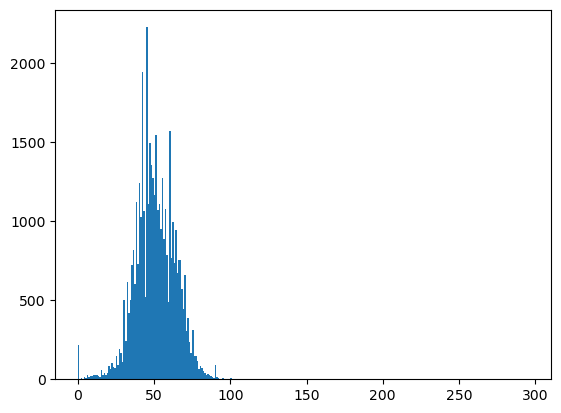

In [14]:
# process all treatment amount columns: if value > 600, drop
df = last_df.copy() # always work on a fresh copy of last step's output

# List of the columns to check for values greater than 600
treatment_amount_columns = [
    "ptindweek1", "ptconweek1", "ptgrpweek1", "ptcoweek1",
    "otindweek1", "otconweek1", "otgrpweek1", "otcoweek1",
    "slpindweek1", "slpconweek1", "slpgrpweek1", "slpcoweek1",
    "ptindweek2", "ptconweek2", "ptgrpweek2", "ptcoweek2",
    "otindweek2", "otconweek2", "otgrpweek2", "otcoweek2",
    "slpindweek2", "slpconweek2", "slpgrpweek2", "slpcoweek2"
]

print(f"# of rows before: {df.shape[0]}")

df = df[~(df[treatment_amount_columns] > 600).any(axis=1)]

print(f"# of rows after: {df.shape[0]}")


# add new columns
for dept in ['pt', 'ot', 'slp']:
    for cell in ['ind', 'con', 'grp', 'co']:
        # Sum week1 and week2 (not week1 + week1)
        week1_col = dept + cell + 'week1'
        week2_col = dept + cell + 'week2'
        df[dept+cell+'week1+2'] = df[week1_col] + df[week2_col]
        # Vectorized conditional division
        df[dept+cell+'perday'] = df[dept+cell+'week1+2'] / np.where(df['los'] <= 14, df['los'], 14)
        df[dept+cell+'extrap'] = df[dept+cell+'perday'] * df['los']

import matplotlib.pyplot as plt

# Plot with matplotlib
plt.hist(df['ptindperday'].values, bins='auto')
plt.show()



#### Column: "transport_lack"

In [15]:
# safe buffer
last_df = df

In [16]:
# process "transport_lack": group up 5 related columns
df = last_df.copy() # always work on a fresh copy of last step's output

print(df["transport_lack"].unique())
print(df["transport_lack_med"].unique())
print(df["transport_lack_nonmed"].unique())
print(df["transport_lack_unable"].unique())
print(df["transport_lack_declined"].unique())

df.loc[(df['transport_lack_unable'] == 'Yes') | (df['transport_lack_declined'] == 'Yes'), 'transport_lack'] = np.nan
df.loc[(df['transport_lack_med'] == 'Yes') | (df['transport_lack_nonmed'] == 'Yes'), 'transport_lack'] = 'Yes'

print(df["transport_lack"].unique())

['No' nan]
[nan 'Yes']
[nan 'Yes']
[nan 'Yes']
[nan 'Yes']
['No' nan 'Yes']


#### Column: "language"

In [17]:
# safe buffer
last_df = df

In [18]:
# process column "language": English or Non-English
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_feature_set.add('language')

print(df['language'].unique())
df['language'] = df['language'].str.contains('eng|enlish', case=False, na=False)
df['language'] = df['language'].map({True: 'English', False: 'Non-English'})
print(df['language'].unique())

['English' 'ENGLISH' 'Spanish' 'Other' 'eng' 'english' 'spanish' 'SPANISH'
 'Vietnamese' 'Unknown' 'Polish' 'English and Spanish' 'Creole' 'Eng'
 'MANDARIN' 'Cambodia' 'Chinese' 'Korean' 'Englissh' 'HINDI' 'Enlglish'
 'POLISH' 'Sindhi/Urdu then English' 'French' 'Farsi' 'Panjabi' 'Mandarin'
 'Japanese' 'Malayalam' 'Ghana' 'Cambodian' 'ENLGISH' 'Indonesian'
 'tagalog' 'Swahili' 'Estonian' 'Portuguese' 'Cantonese'
 'Chinese, Mandarin' 'gujarati' 'German' 'other' 'Hmong' 'English/Spanish'
 'Russian' 'Englsih' 'Karen' 'Arabic' 'CREOLE' 'Undetermined' 'Gujarati'
 'Urdu' 'BANGLADESH' 'Hindi' 'Tagalog' 'TOISAN' 'Spanish and English'
 'Chinese - Canto' 'korean' 'creole' 'ASL' 'WHITE' 'Italian'
 'ENGLISH/TURKISH' 'Haitian' 'TAGALOG' 'en' 'CANTONESE' 'ENglish'
 'CHINESE' 'Serbian' 'Ukrainian' 'Persian' 'Swedish' 'English, Spanish'
 'Enbglish' 'Bosnian' 'Albanian' 'LAO' 'chinese' 'Chinese - Manda'
 'Slovak' 'French Creole' 'English, Other' 'ukranian' 'ENGLSIH' 'Enlish'
 'Chuukese' 'VIETNAMESE' 'A

#### Column: "hispanic"

In [19]:
# safe buffer
last_df = df

In [20]:
# process column "hispanic" (ethnicity): English or Non-English
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_feature_set.add('hispanic')
print("nan count before:", pd.isna(df['hispanic']).sum())

# 1. fill 'Yes' where any of the hispanic subcategories are 'Yes'
hispanic_yes_cols = ['hispanic_mexican', 'hispanic_puertorican', 'hispanic_cuban', 'hispanic_other']
df.loc[df['hispanic'].isna() & (df[hispanic_yes_cols] == 'Yes').any(axis=1), 'hispanic'] = 'Yes'

# 2. fill 'No' where hispanic_unable or hispanic_declined are 'Yes'
hispanic_no_cols = ['hispanic_unable', 'hispanic_declined']
df.loc[df['hispanic'].isna() & (df[hispanic_no_cols] == 'Yes').any(axis=1), 'hispanic'] = 'No'

# 3. for rows where 'hispanic' is still NaN, fill it with 'No'
df['hispanic'].fillna('No', inplace=True)

print("nan count after:", pd.isna(df['hispanic']).sum())
print(df['hispanic'].unique())


nan count before: 4404
nan count after: 0
['No' 'Yes']


#### Column: "race"

In [21]:
# safe buffer
last_df = df

In [22]:
df = last_df.copy()  # Always work on a fresh copy of the last step's output

# Define race categories based on revised standards
categorical_feature_set.add('race')

# Grouping races according to new categories
race_is_american_indian = df[['race_alaskan']].eq('Yes').any(axis=1)
race_is_asian = df[['race_chinese', 'race_japanese', 'race_korean', 'race_filipino', 
                    'race_vietnamese', 'race_asianother', 'race_asianindian']].eq('Yes').any(axis=1)
race_is_black = df['race_black'].eq('Yes')
race_is_pacific_islander = df[['race_hawaiian', 'race_guam', 'race_samoan', 
                               'race_pacificislander_other']].eq('Yes').any(axis=1)
race_is_white = df['race_white'].eq('Yes')
race_is_unknown = df[['race_unable', 'race_declined', 'race_noneoftheabove']].eq('Yes').any(axis=1)

# Create a new column for 'race' with default value as NaN
df['race'] = np.nan
df['race'] = df['race'].astype('object')

# Assign values based on the grouping
df.loc[race_is_american_indian, 'race'] = 'American_Indian_or_Alaska_Native'
df.loc[race_is_asian, 'race'] = 'Asian'
df.loc[race_is_black, 'race'] = 'Black_or_African_American'
df.loc[race_is_pacific_islander, 'race'] = 'Native_Hawaiian_or_Other_Pacific_Islander'
df.loc[race_is_white, 'race'] = 'White'

# Handling multiple races marked as "Yes"
multiple_races = (df[['race_white', 'race_black', 'race_alaskan', 'race_chinese', 
                      'race_japanese', 'race_korean', 'race_filipino', 'race_vietnamese', 
                      'race_asianother', 'race_asianindian', 'race_hawaiian', 'race_guam', 
                      'race_samoan', 'race_pacificislander_other']]
                  .eq('Yes').sum(axis=1) > 1)
df.loc[multiple_races, 'race'] = 'Multiracial'

# Fill remaining NaN values with 'Unknown'
df['race'].fillna('Unknown', inplace=True)

# Print results for validation
print("nan count after:", pd.isna(df['race']).sum())
print(df['race'].unique())


nan count after: 0
['White' 'Black_or_African_American' 'Unknown' 'Asian'
 'American_Indian_or_Alaska_Native'
 'Native_Hawaiian_or_Other_Pacific_Islander' 'Multiracial']


#### Combining clinically meaningful ranked int feature values
If we need clinically meaningful variables, these variables should end up being categorical

In [23]:
cm_ri_variables = [ # clinically meaningful ranked int variables
    "hearing_adm",
    "vision_adm",
    "health_lit_adm",
    "bims_total",
    "socisolation_adm",
    "bladder_incontinence",
    "bowel_incontinence",
    "pain_sleep_adm",
    "pain_therapy_adm",
    "pain_activities_adm",
]

In [24]:
# safe buffer
last_df = df

In [25]:
if CLINICALLY_MEANINGFUL:
    
    df = last_df.copy()  # Always work on a fresh copy of the last step's output

    for varname in cm_ri_variables:
        categorical_feature_set.add(varname)
        print(f"-----var {varname}-----")
        print(f"before uniques: {df[varname].unique()}")
        if varname in ["hearing_adm"]:
            df[varname] = df[varname].replace({
                "Adequate": "Not_impaired",
                "Min_difficulty": "Not_impaired",
                "Mod_difficulty": "Impaired",
                "Highly_impaired": "Impaired",
            })
        elif varname in ["vision_adm"]:
            df[varname] = df[varname].replace({
                "Adequate": "Not_impaired",
                "Impaired": "Not_impaired", # I know this looked weird but `section B C adm.xlsx` recorded this way
                "Mod_impaired": "Impaired",
                "Highly_impaired": "Impaired",
                "Severely_impaired": "Impaired",
            })
        elif varname in ["health_lit_adm", "socisolation_adm"]:
            df[varname] = df[varname].replace({
                "Never": "No",
                "Rarely": "No",
                "Often": "Yes",
                "Sometimes": "Yes",
                "Always": "Yes",
                "Unable": "Unknown",
                "Decline": "Unknown",
            })
        elif varname in ["bims_total"]:
            df[varname] = df[varname].replace({
                "unable_to_complete": np.nan
            }).apply(lambda x: int(float(x)) if pd.notna(x) else pd.NA).astype('Int64')
            def categorize_bims(score):
                if pd.isna(score):
                    return 'Unable_to_complete'
                elif score <= 7:
                    return 'Severe'
                elif 7 < score < 13:
                    return 'Moderate'
                elif score >= 13:
                    return 'Intact'
                else:
                    return 'Unable_to_complete'
            # Create new column with categories
            df[varname] = df[varname].apply(categorize_bims)
        elif varname in ['bladder_incontinence']:
            df[varname] = df[varname].replace({
                "Continent": "Continent",
                "Stress_incont": "Continent",
                "Incontinent": "Incontinent",
                "Incont_weekly": "Incontinent",
                "Incont_daily": "Incontinent",
                "Not_applicable": "Unknown",
                "No_output": "Unknown",
            })
        elif varname in ['bowel_incontinence']:
            df[varname] = df[varname].replace({
                "Continent": "Continent",
                "Occ_incont": "Incontinent",
                "Freq_incont": "Incontinent",
                "Incontinent": "Incontinent",
                "Not_rated": "Unknown",
            })
        elif varname in ['pain_sleep_adm', 'pain_therapy_adm', 'pain_activities_adm']:
            df[varname] = df[varname].replace({
                "does_not_apply": "No",
                "Rarely": "No",
                "occasionally": "Yes",
                "frequently": "Yes",
                "constantly": "Yes",
                "unable": "Unknown",
                pd.NA: "Unknown",
            })
        print(f"after uniques: {df[varname].unique()}")

-----var hearing_adm-----
before uniques: ['Adequate' 'Mod_difficulty' 'Min_difficulty' 'Highly_impaired']
after uniques: ['Not_impaired' 'Impaired']
-----var vision_adm-----
before uniques: ['Adequate' 'Impaired' 'Mod_impaired' 'Highly_impaired'
 'Severely_impaired']
after uniques: ['Not_impaired' 'Impaired']
-----var health_lit_adm-----
before uniques: ['Never' 'Rarely' 'Unable' 'Often' 'Sometimes' 'Always' 'Decline']
after uniques: ['No' 'Unknown' 'Yes']
-----var bims_total-----
before uniques: ['unable_to_complete' '15.0' nan '6.0' '14.0' '7.0' '11.0' '5.0' '13.0'
 '3.0' '4.0' '12.0' '9.0' '10.0' '8.0' '0.0' '1.0' '2.0']
after uniques: ['Unable_to_complete' 'Intact' 'Severe' 'Moderate']
-----var socisolation_adm-----
before uniques: ['Never' 'Unable' 'Sometimes' 'Rarely' 'Often' 'Always' 'Decline']
after uniques: ['No' 'Unknown' 'Yes']
-----var bladder_incontinence-----
before uniques: ['Continent' 'Incontinent' 'Incont_weekly' 'Not_applicable' 'Incont_daily'
 'Stress_incont' 'No_o

#### Column: all bool features
**NaNs**: There shouldn't be any NaN left after processing.

In [26]:
# safe buffer
last_df = df

In [27]:
# bool features are generally recorded as "Yes" / "No" in raw data; covert to 0 / 1
df = last_df.copy() # always work on a fresh copy of last step's output

binary_features = [
    "arthritis",
    # "transport_lack_med",
    # "transport_lack_nonmed",
    "conduct_bims",
    "conduct_sams",
    "sams_season",
    "sams_room",
    "sams_names",
    "sams_hosp",
    "sams_none_above",
    "acute_mental_change",
    "wc_manual_prior",
    "wc_motor_prior",
    "mechlift_prior",
    "walker_prior",
    "orth_pros_prior",
    "no_device_prior",
    "wc_user",
    "pvd_comorbid",
    "diabetes_comorbid",
    "nutrition_parenteral_adm",
    "nutrition_tube_adm",
    "nutrition_mech_diet_adm",
    "nutrition_ther_diet_adm",
    "pressure_ulcer_adm", # new
    "antipsychotic_taking_adm",
    "antipsychotic_ind_adm",
    "anticoagulant_taking_adm",
    "anticoagulant_ind_adm",
    "antibiotic_taking_adm",
    "antibiotic_ind_adm",
    "opioid_taking_adm",
    "opioid_ind_adm",
    "antiplatelet_taking_adm",
    "antiplatelet_ind_adm",
    "hypoglycemic_taking_adm",
    "hypoglycemic_ind_adm",
    "chemo_adm",
    "chemo_iv_adm",
    "chemo_oral_adm",
    "chemo_other_adm",
    "radiation_adm",
    "oxygen_adm",
    "oxygen_cont_adm",
    "oxygen_int_adm",
    "oxygen_high_adm",
    "suctioning_adm",
    "suctioning_sched_adm",
    "suctioning_asneeded_adm",
    "trach_adm",
    "vent_invasive_adm",
    "vent_noninvasive_adm",
    "vent_bipap_adm",
    "vent_cpap_adm",
    "meds_iv_adm",
    "meds_iv_vasoactive_adm",
    "meds_iv_antibiotic_adm",
    "meds_iv_anticoagulant_adm",
    "meds_iv_other_adm",
    "transfusions_adm",
    "dialysis_adm",
    "hemodialysis_adm",
    "peritoneal_dialysis_adm",
    "iv_access_adm",
    "iv_access_periph_adm",
    "iv_access_mid_adm",
    "iv_access_cent_adm",
]
for name in binary_features:
    binary_feature_set.add(name)
    print(f"----------working on: {name}----------")
    df[name] = df[name].apply(lambda x: x.lower() if isinstance(x, str) else x) # lower-casify first
    uniques = set(df[name].unique())
    print("uniques before:", uniques)
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if uniques == {0, 1}: # already processed
        continue
    if name == "conduct_sams":
        df[name].fillna("yes", inplace=True)
        df[name].replace({
            "yes": 1,
            "no": 0,
        }, inplace=True)
    elif name in {"sams_season","sams_room","sams_names","sams_hosp"}: # default: yes for all those completed BIMS
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 1,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    elif name == "sams_none_above":
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 0,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    elif '_ind_' in name:
        df[name].replace({
            "no": 0,
            "yes": 1,
            np.nan: 0,
        }, inplace=True)
        df[name] = df[name].astype('int64')
    else: # default behavior
        if uniques == {np.nan, "yes"}:
            df[name].fillna("no", inplace=True)
        elif uniques == {np.nan, "no"}:
            df[name].fillna("yes", inplace=True)
        elif uniques != {"yes", "no"}:
            raise Exception(f"{name} is not a binary feature")
        df[name].replace({
            "yes": 1,
            "no": 0,
        }, inplace=True)
    print("uniques after:", df[name].unique())
    if set(df[name].unique()) != {0, 1}:
        raise Exception(f"{name} is not well-formated, double check!")
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())

----------working on: arthritis----------
uniques before: {'yes', 'no'}
dtype before: object
nan count before: 0
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: conduct_bims----------
uniques before: {'yes', 'no'}
dtype before: object
nan count before: 0
uniques after: [1 0]
dtype after: int64
nan count after: 0
----------working on: conduct_sams----------
uniques before: {'yes', nan, 'no'}
dtype before: object
nan count before: 3837
uniques after: [1 0]
dtype after: int64
nan count after: 0
----------working on: sams_season----------
uniques before: {'yes', nan, 'no'}
dtype before: object
nan count before: 38280
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: sams_room----------
uniques before: {'yes', nan, 'no'}
dtype before: object
nan count before: 38280
uniques after: [0 1]
dtype after: int64
nan count after: 0
----------working on: sams_names----------
uniques before: {'yes', nan, 'no'}
dtype before: object
nan cou

#### Column: all ranked integer features
**NaNs**: Leave them alone. Different imputation strategies can be applied later.

In [28]:
# safe buffer
last_df = df

In [29]:
# each case may need separate handling
df = last_df.copy() # always work on a fresh copy of last step's output

ranked_int_features = [
    "admityear",
    "hearing_adm",
    "vision_adm",
    "health_lit_adm",
    "expression_adm",
    "understand_verbal_adm",
    "bims_3words",
    "bims_year",
    "bims_month",
    "bims_day",
    "bims_recall_sock",
    "bims_recall_blue",
    "bims_recall_bed",
    "bims_total",
    "low_interest_adm",
    "low_interest_freq_adm",
    "depressed_adm",
    "depressed_freq_adm",
    "sleep_trouble_adm",
    "sleep_trouble_freq_adm",
    "tired_adm",
    "tired_freq_adm",
    "appetite_adm",
    "appetite_freq_adm",
    "feel_bad_adm",
    "feel_bad_freq_adm",
    "concentrate_adm",
    "concentrate_freq_adm",
    "slowfast_adm",
    "slowfast_freq_adm",
    "selfharm_adm",
    "selfharm_freq_adm",
    "mood_total_adm",
    "socisolation_adm",
    "selfcare_prior",
    "mobility_prior",
    "stairs_prior",
    "func_cog_prior",
    "eating_adm",
    "oral_adm",
    "toileting_adm",
    "bathe_adm",
    "dress_upper_adm",
    "dress_lower_adm",
    "footwear_adm",
    "roll_lr_adm",
    "sit_lying_adm",
    "lying_sit_adm",
    "sit_stand_adm",
    "bed_chair_adm",
    "toilet_trans_adm",
    "car_trans_adm",
    "walk10ft_adm",
    "walk50ft_adm",
    "walk150ft_adm",
    "walk10ft_uneven_adm",
    "walk1step_adm",
    "walk4step_adm",
    "walk12step_adm",
    "pickup_adm",
    "wheel50ft_adm",
    "wheel150ft_adm",
    "bladder_incontinence",
    "bowel_incontinence",
    "pain_sleep_adm",
    "pain_therapy_adm",
    "pain_activities_adm",
    "stage1_pu_adm",
    "stage2_pu_adm",
    "stage3_pu_adm",
    "stage4_pu_adm",
    "unstageable_dressing_pu_adm",
    "unstageable_slough_pu_adm",
    "unstageable_deep_pu_adm",
    "med_follow_up",
]

for name in ranked_int_features:
    if CLINICALLY_MEANINGFUL and name in cm_ri_variables:
        continue
    ranked_int_feature_set.add(name)
    print(f"----------working on: {name}----------")
    print("uniques before:", df[name].unique())
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if name == "admityear": # simply replace float as int
        df[name] = df[name].apply(lambda x: int(x))
    elif name == "health_lit_adm":
        inverse_lookup = {v:k for k, v in lookup_table[name].items()}
        possible_nan_keys = ["Decline", "Unable", "Refuse"]
        for k in possible_nan_keys:
            inverse_lookup[k] = np.nan
        df[name].replace(inverse_lookup, inplace=True)
        df[name] = df[name].apply(lambda x: int(x) if pd.notna(x) else pd.NA).astype('Int64')
    elif name == "bims_total":
        df[name].replace({'unable_to_complete': pd.NA,
                          np.nan: pd.NA}, inplace=True)
        df[name] = df[name].apply(lambda x: int(float(x)) if pd.notna(x) else pd.NA).astype('Int64')
    else: # default behavior
        inverse_lookup = {v:k for k, v in lookup_table[name].items()}
        possible_nan_keys = [
            "Decline",
            "Unable", "unable"
            "Refuse",
            "No_response",
            "Unknown",
            "Not_applicable",
            "Not_attempted",
            "Safety",
            "Not_rated",
            ]
        for k in possible_nan_keys:
            inverse_lookup[k] = np.nan
        df[name].replace(inverse_lookup, inplace=True)
        df[name] = df[name].apply(lambda x: int(float(x)) if pd.notna(x) else pd.NA).astype('Int64')
    print("uniques after:", df[name].unique())
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())
        

----------working on: admityear----------
uniques before: [2023. 2022.]
dtype before: float64
nan count before: 0
uniques after: [2023 2022]
dtype after: int64
nan count after: 0
----------working on: expression_adm----------
uniques before: ['Freq_difficulty' 'No_difficulty' 'Never_expresses' 'Some_difficulty']
dtype before: object
nan count before: 0
uniques after: <IntegerArray>
[2, 4, 1, 3]
Length: 4, dtype: Int64
dtype after: Int64
nan count after: 0
----------working on: understand_verbal_adm----------
uniques before: ['sometimes_understands' 'Understands' 'Rarely_understands'
 'Usually_understands']
dtype before: object
nan count before: 0
uniques after: <IntegerArray>
[2, 4, 1, 3]
Length: 4, dtype: Int64
dtype after: Int64
nan count after: 0
----------working on: bims_3words----------
uniques before: ['Zero' 'Three' nan 'Two' 'One']
dtype before: object
nan count before: 3837
uniques after: <IntegerArray>
[0, 3, <NA>, 2, 1]
Length: 5, dtype: Int64
dtype after: Int64
nan count a

#### Column: all numeric columns
**NaNs**: Leave them alone. Different imputation strategies can be applied later.

In [30]:
# safe buffer
last_df = df

In [31]:
# replace nan with "Unknown", replace spaces with underscores
df = last_df.copy() # always work on a fresh copy of last step's output

numeric_features = [
    "heightinches",
    "weightpounds",
    "ptindweek1",
    "ptconweek1",
    "ptgrpweek1",
    "ptcoweek1",
    "otindweek1",
    "otconweek1",
    "otgrpweek1",
    "otcoweek1",
    "slpindweek1",
    "slpconweek1",
    "slpgrpweek1",
    "slpcoweek1",
    "ptindweek2",
    "ptconweek2",
    "ptgrpweek2",
    "ptcoweek2",
    "otindweek2",
    "otconweek2",
    "otgrpweek2",
    "otcoweek2",
    "slpindweek2",
    "slpconweek2",
    "slpgrpweek2",
    "slpcoweek2",
    "ptindweek1+2",
    "ptconweek1+2",
    "ptgrpweek1+2",
    "ptcoweek1+2",
    "otindweek1+2",
    "otconweek1+2",
    "otgrpweek1+2",
    "otcoweek1+2",
    "slpindweek1+2",
    "slpconweek1+2",
    "slpgrpweek1+2",
    "slpcoweek1+2",
    "ptindperday",
    "ptconperday",
    "ptgrpperday",
    "ptcoperday",
    "otindperday",
    "otconperday",
    "otgrpperday",
    "otcoperday",
    "slpindperday",
    "slpconperday",
    "slpgrpperday",
    "slpcoperday",
    "age_at_admit",
    "los",
    "ric",
    "cmg",
    "selfcare_measure_adm",
    "mobility_measure_adm"
]
# TODO

for name in numeric_features:
    numeric_feature_set.add(name)

#### Column: all categorical columns

**NaNs**: Simply set as "Unknwon". Later if imputation is needed you can still do so.

In [32]:
# safe buffer
last_df = df

In [33]:
# replace nan with "Unknown", replace spaces with underscores
df = last_df.copy() # always work on a fresh copy of last step's output

categorical_features = [
    "sex",
    "marital_status",
    "admitclass",
    "admit_from",
    "prehospital_living",
    "transport_lack", # grouped from 5 original columns
    "payor_primary",
    "inattention_adm",
    "disorganized_adm",
    "altered_adm",
    "wc50_type",
    "wc150_type",
    "falls_hx",
    "prior_surgery",
    "drug_regimen_review",
    "tier",
    "low_interest_adm",
    "depressed_adm",
    "stroke_type", # new
]   

for name in categorical_features:
    categorical_feature_set.add(name)
    print(f"----------working on: {name}----------")
    print("uniques before:", df[name].unique())
    print("dtype before:", df[name].dtype)
    print("nan count before:", pd.isna(df[name]).sum())
    if name in {"tier"}: # categorical but labels are integers
        df[name] = df[name].apply(lambda x: str(int(float(x))) if pd.notna(x) else "Unknown").astype(str)
    
    else: # default behavior
        df[name] = df[name].apply(lambda x: str(x).replace(' ', '_') if pd.notna(x) else "Unknown").astype(str)
    print("uniques after:", df[name].unique())
    print("dtype after:", df[name].dtype)
    print("nan count after:", pd.isna(df[name]).sum())

----------working on: sex----------
uniques before: ['female' 'male']
dtype before: object
nan count before: 0
uniques after: ['female' 'male']
dtype after: object
nan count after: 0
----------working on: marital_status----------
uniques before: ['Married' 'Unmarried' nan]
dtype before: object
nan count before: 2469
uniques after: ['Married' 'Unmarried' 'Unknown']
dtype after: object
nan count after: 0
----------working on: admitclass----------
uniques before: ['Initial' 'Other' 'Readmission' nan]
dtype before: object
nan count before: 3784
uniques after: ['Initial' 'Other' 'Readmission' 'Unknown']
dtype after: object
nan count after: 0
----------working on: admit_from----------
uniques before: ['Short-term hospital' 'Home-based' 'Other facility']
dtype before: object
nan count before: 0
uniques after: ['Short-term_hospital' 'Home-based' 'Other_facility']
dtype after: object
nan count after: 0
----------working on: prehospital_living----------
uniques before: ['Home' 'Facility']
dtype 

#### Save

In [34]:
# show processed features
feature_names = [*df.head()]
processed_feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))
print(tabulate([(index, name, processed_feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))

total # of features: 491
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | int64   |
+---------+--------------------------------+---------+
|       3 | admitclass                     | object  |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

In [35]:
# save processed data with 6 extra columns

df.to_csv('./data/Cleaned files/Cogan_1_3.csv', index=True)

In [36]:
# save feature table & dtype dictionary
import pickle
import json

feature_table = {
    "categorical": list(categorical_feature_set),
    "numeric": list(numeric_feature_set),
    "ranked_int": list(ranked_int_feature_set),
    "binary": list(binary_feature_set),
}

with open("./data/Cleaned files/feature_table.pkl", 'wb') as f:
    pickle.dump(feature_table, f)

dtype_dict = {name: str(df[name].dtype) for name in df.columns}

with open('./data/Cleaned files/processed_feature_dtypes.json', 'w') as f:
    json.dump(dtype_dict, f)

## 2 Feature Selection, One-Hot Expansion & Imputation

### 2.1 Interested Feature Manual Selection & Dropping Invalid Samples, Splitting Dataset

In [76]:
# total # of features and a list of all feature names

FEATURE_SET = ['comprehensive', 'core'][1]

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_1_3.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

total # of features: 491
+---------+--------------------------------+---------+
|   Index | Name                           | Dtype   |
+=========+================================+=========+
|       0 | sex                            | object  |
+---------+--------------------------------+---------+
|       1 | marital_status                 | object  |
+---------+--------------------------------+---------+
|       2 | admityear                      | int64   |
+---------+--------------------------------+---------+
|       3 | admitclass                     | object  |
+---------+--------------------------------+---------+
|       4 | admit_from                     | object  |
+---------+--------------------------------+---------+
|       5 | prehospital_living             | object  |
+---------+--------------------------------+---------+
|       6 | prehospital_living_with        | object  |
+---------+--------------------------------+---------+
|       7 | payor_primary               

#### 2.1.a Comprehensive Variable Set (Legacy)

In [77]:
if FEATURE_SET == 'comprehensive':    
    # define predictors and outcomes
    interested_predictors = [
        # >>> base info >>>
        "sex", # male / female
        "marital_status", # ['Married' 'Widowed' 'Unknown' 'Divorced' 'Separated' 'Never_married']
        "admitclass",
        "admit_from",
        "prehospital_living",
        "payor_primary",
        # "impgroupadmit", # what does this do?
        # "diagnosis", # need a pretrained LM for embedding
        "stroke_type", # now we simplify diagnosis as stroke type
        "arthritis", 
        "heightinches",
        "weightpounds",
        # <<< base info <<<

        # >>> therapies >>>
        "ptindweek1",
        "ptconweek1",
        "ptgrpweek1",
        "ptcoweek1",
        "otindweek1",
        "otconweek1",
        "otgrpweek1",
        "otcoweek1",
        "slpindweek1",
        "slpconweek1",
        "slpgrpweek1",
        "slpcoweek1",
        "ptindweek2",
        "ptconweek2",
        "ptgrpweek2",
        "ptcoweek2",
        "otindweek2",
        "otconweek2",
        "otgrpweek2",
        "otcoweek2",
        "slpindweek2",
        "slpconweek2",
        "slpgrpweek2",
        "slpcoweek2",
        # <<< therapies <<<

        # >>> section A admission >>>
        "hispanic", # ethnicity, Yes or No
        "race", # integrated race categorical field
        "language", # integrated language categorical field: English or Non-English
        "transport_lack",
        # "transport_lack_med",
        # "transport_lack_nonmed",
        # <<< section A admission <<<
        
        # >>> section B C admission >>>
        "hearing_adm",
        "vision_adm",
        "health_lit_adm",
        "expression_adm",
        "understand_verbal_adm",
        "conduct_bims", # bims: Brief Interview for Mental Status
        # "bims_3words",
        # "bims_year",
        # "bims_month",
        # "bims_day",
        # "bims_recall_sock",
        # "bims_recall_blue",
        # "bims_recall_bed",
        "bims_total",
        "conduct_sams", # only if "conduct_bims" is false, conduct Staff Assessment for Mental Status
        "sams_season",
        "sams_room",
        "sams_names",
        "sams_hosp",
        # "sams_none_above", # don't include this since it's inferable from others
        "acute_mental_change",
        "inattention_adm",
        "disorganized_adm",
        "altered_adm",
        # <<< section B C admission <<<
        
        # >>> section D admission >>>
        # "low_interest_adm",
        # "low_interest_freq_adm",
        # "depressed_adm",
        # "depressed_freq_adm",
        # "sleep_trouble_adm",
        # "sleep_trouble_freq_adm",
        # "tired_adm",
        # "tired_freq_adm",
        # "appetite_adm",
        # "appetite_freq_adm",
        # "feel_bad_adm",
        # "feel_bad_freq_adm",
        # "concentrate_adm",
        # "concentrate_freq_adm",
        # "slowfast_adm",
        # "slowfast_freq_adm",
        # "selfharm_adm",
        # "selfharm_freq_adm",
        "mood_total_adm", # total alone is enough to cover all above
        "socisolation_adm",
        # <<< section D admission <<<

        # >>> section GG admission >>>
        "selfcare_prior",
        "mobility_prior",
        "stairs_prior",
        "func_cog_prior",
        "wc_manual_prior",
        "wc_motor_prior",
        "mechlift_prior",
        "walker_prior",
        "orth_pros_prior",
        # "no_device_prior", # can be inferred
        # "eating_adm",
        # # "eating_goal",
        # "oral_adm",
        # # "oral_goal",
        # "toileting_adm",
        # # "toileting_goal",
        # "bathe_adm",
        # # "bathe_goal",
        # "dress_upper_adm",
        # # "dress_upper_goal",
        # "dress_lower_adm",
        # # "dress_lower_goal",
        # "footwear_adm",
        # # "footwear_goal",
        # "roll_lr_adm",
        # # "roll_lr_goal",
        # "sit_lying_adm",
        # # "sit_lying_goal",
        # "lying_sit_adm",
        # # "lying_sit_goal",
        # "sit_stand_adm",
        # # "sit_stand_goal",
        # "bed_chair_adm",
        # # "bed_chair_goal",
        # "toilet_trans_adm",
        # # "toilet_trans_goal",
        # "car_trans_adm",
        # # "car_trans_goal",
        # "walk10ft_adm",
        # # "walk10ft_goal",
        # "walk50ft_adm",
        # # "walk50ft_goal",
        # "walk150ft_adm",
        # # "walk150ft_goal",
        # "walk10ft_uneven_adm",
        # # "walk10ft_uneven_goal",
        # "walk1step_adm",
        # # "walk1step_goal",
        # "walk4step_adm",
        # # "walk4step_goal",
        # "walk12step_adm",
        # # "walk12step_goal",
        # "pickup_adm",
        # # "pickup_goal",
        "selfcare_measure_adm", # added in section 1.2
        "mobility_measure_adm", # added in section 1.2
        "wc_user", # inferable, but still preserved
        "wheel50ft_adm",
        # "wheel50ft_goal",
        "wc50_type",
        "wheel150ft_adm",
        # "wheel150ft_goal",
        "wc150_type",
        # <<< section GG admission <<<

        # >>> section H I J K M N O admission >>>
        "bladder_incontinence",
        "bowel_incontinence",
        "pvd_comorbid",
        "diabetes_comorbid",
        # "no_comorbidities", # inferable
        "pain_sleep_adm",
        "pain_therapy_adm",
        "pain_activities_adm",
        "falls_hx",
        "prior_surgery",
        "nutrition_parenteral_adm",
        "nutrition_tube_adm",
        "nutrition_mech_diet_adm",
        "nutrition_ther_diet_adm",
        # "nutrition_none_adm", # inferable
        # "pressure_ulcer_adm", #inferable
        "stage1_pu_adm",
        "stage2_pu_adm",
        "stage3_pu_adm",
        "stage4_pu_adm",
        "unstageable_dressing_pu_adm",
        "unstageable_slough_pu_adm",
        "unstageable_deep_pu_adm",
        "antipsychotic_taking_adm",
        "antipsychotic_ind_adm",
        "anticoagulant_taking_adm",
        "anticoagulant_ind_adm",
        "antibiotic_taking_adm",
        "antibiotic_ind_adm",
        "opioid_taking_adm",
        "opioid_ind_adm",
        "antiplatelet_taking_adm",
        "antiplatelet_ind_adm",
        "hypoglycemic_taking_adm",
        "hypoglycemic_ind_adm",
        # "med_highrisk_none", # inferable
        "drug_regimen_review",
        "med_follow_up",
        "chemo_adm",
        "chemo_iv_adm",
        "chemo_oral_adm",
        "chemo_other_adm",
        "radiation_adm",
        "oxygen_adm",
        "oxygen_cont_adm",
        "oxygen_int_adm",
        "oxygen_high_adm",
        "suctioning_adm",
        "suctioning_sched_adm",
        "suctioning_asneeded_adm",
        "trach_adm",
        "vent_invasive_adm",
        "vent_noninvasive_adm",
        "vent_bipap_adm",
        "vent_cpap_adm",
        "meds_iv_adm",
        "meds_iv_vasoactive_adm",
        "meds_iv_antibiotic_adm",
        "meds_iv_anticoagulant_adm",
        "meds_iv_other_adm",
        "transfusions_adm",
        "dialysis_adm",
        "hemodialysis_adm",
        "peritoneal_dialysis_adm",
        "iv_access_adm",
        "iv_access_periph_adm",
        "iv_access_mid_adm",
        "iv_access_cent_adm",
        # "tx_none_adm", # inferable
        # <<< section H I J K M N O admission <<<

        # >>> the rest >>>
        "age_at_admit",
        "los",
        "ric",
        "cmg",
        "tier",
        # "shortstayexpired",
        # "shortstaycmg",
        # "transferpatient",
        # "incompletestay",
        # <<< the rest <<<

    ]

    therapy_predictors = [x for x in interested_predictors if "week1" in x or "week2" in x]
    print(therapy_predictors)

    interested_outcomes = [
        "selfcare_measure_delta", # added in section 1.2
        "mobility_measure_delta" # added in section 1.2
    ]

#### 2.1.b Core Variable Set

In [78]:
if FEATURE_SET == 'core':
    # define predictors and outcomes
    interested_predictors = [
        # >>> base info >>>
        "sex", # male / female
        "marital_status", # ['Married' 'Widowed' 'Unknown' 'Divorced' 'Separated' 'Never_married']
        # "admitclass",
        # "admit_from",
        # "prehospital_living",
        "payor_primary",
        # "impgroupadmit", # what does this do?
        # "diagnosis", # need a pretrained LM for embedding
        "stroke_type", # now we simplify diagnosis as stroke type
        # "arthritis", 
        # "heightinches",
        # "weightpounds",
        # <<< base info <<<

        # >>> therapies >>>
        "ptindweek1",
        # "ptconweek1",
        # "ptgrpweek1",
        # "ptcoweek1",
        "otindweek1",
        # "otconweek1",
        # "otgrpweek1",
        # "otcoweek1",
        "slpindweek1",
        # "slpconweek1",
        # "slpgrpweek1",
        # "slpcoweek1",
        "ptindweek2",
        # "ptconweek2",
        # "ptgrpweek2",
        # "ptcoweek2",
        "otindweek2",
        # "otconweek2",
        # "otgrpweek2",
        # "otcoweek2",
        "slpindweek2",
        # "slpconweek2",
        # "slpgrpweek2",
        # "slpcoweek2",
        "ptindweek1+2",
        # "ptconweek1+2",
        # "ptgrpweek1+2",
        # "ptcoweek1+2",
        "otindweek1+2",
        # "otconweek1+2",
        # "otgrpweek1+2",
        # "otcoweek1+2",
        "slpindweek1+2",
        # "slpconweek1+2",
        # "slpgrpweek1+2",
        # "slpcoweek1+2",
        "ptindperday",
        # "ptconperday",
        # "ptgrpperday",
        # "ptcoperday",
        "otindperday",
        # "otconperday",
        # "otgrpperday",
        # "otcoperday",
        "slpindperday",
        # "slpconperday",
        # "slpgrpperday",
        # "slpcoperday",
        "ptindextrap",
        # "ptconextrap",
        # "ptgrpextrap",
        # "ptcoextrap",
        "otindextrap",
        # "otconextrap",
        # "otgrpextrap",
        # "otcoextrap",
        "slpindextrap",
        # "slpconextrap",
        # "slpgrpextrap",
        # "slpcoextrap",
        # <<< therapies <<<

        # >>> section A admission >>>
        "hispanic", # ethnicity, Yes or No
        "race", # integrated race categorical field
        # "language", # integrated language categorical field: English or Non-English
        # "transport_lack",
        # "transport_lack_med",
        # "transport_lack_nonmed",
        # <<< section A admission <<<
        
        # >>> section B C admission >>>
        "hearing_adm",
        "vision_adm",
        "health_lit_adm",
        "expression_adm",
        "understand_verbal_adm",
        # "conduct_bims", # bims: Brief Interview for Mental Status
        # "bims_3words",
        # "bims_year",
        # "bims_month",
        # "bims_day",
        # "bims_recall_sock",
        # "bims_recall_blue",
        # "bims_recall_bed",
        "bims_total",
        # "conduct_sams", # only if "conduct_bims" is false, conduct Staff Assessment for Mental Status
        # "sams_season",
        # "sams_room",
        # "sams_names",
        # "sams_hosp",
        # "sams_none_above", # don't include this since it's inferable from others
        "acute_mental_change",
        # "inattention_adm",
        # "disorganized_adm",
        # "altered_adm",
        # <<< section B C admission <<<
        
        # >>> section D admission >>>
        "low_interest_adm",
        # "low_interest_freq_adm",
        "depressed_adm",
        # "depressed_freq_adm",
        # "sleep_trouble_adm",
        # "sleep_trouble_freq_adm",
        # "tired_adm",
        # "tired_freq_adm",
        # "appetite_adm",
        # "appetite_freq_adm",
        # "feel_bad_adm",
        # "feel_bad_freq_adm",
        # "concentrate_adm",
        # "concentrate_freq_adm",
        # "slowfast_adm",
        # "slowfast_freq_adm",
        # "selfharm_adm",
        # "selfharm_freq_adm",
        # "mood_total_adm", # total alone is enough to cover all above
        "socisolation_adm",
        # <<< section D admission <<<

        # >>> section GG admission >>>
        "selfcare_prior",
        "mobility_prior",
        # "stairs_prior",
        # "func_cog_prior",
        # "wc_manual_prior",
        # "wc_motor_prior",
        # "mechlift_prior",
        # "walker_prior",
        # "orth_pros_prior",
        # "no_device_prior", # can be inferred
        # "eating_adm",
        # # "eating_goal",
        # "oral_adm",
        # # "oral_goal",
        # "toileting_adm",
        # # "toileting_goal",
        # "bathe_adm",
        # # "bathe_goal",
        # "dress_upper_adm",
        # # "dress_upper_goal",
        # "dress_lower_adm",
        # # "dress_lower_goal",
        # "footwear_adm",
        # # "footwear_goal",
        # "roll_lr_adm",
        # # "roll_lr_goal",
        # "sit_lying_adm",
        # # "sit_lying_goal",
        # "lying_sit_adm",
        # # "lying_sit_goal",
        # "sit_stand_adm",
        # # "sit_stand_goal",
        # "bed_chair_adm",
        # # "bed_chair_goal",
        # "toilet_trans_adm",
        # # "toilet_trans_goal",
        # "car_trans_adm",
        # # "car_trans_goal",
        # "walk10ft_adm",
        # # "walk10ft_goal",
        # "walk50ft_adm",
        # # "walk50ft_goal",
        # "walk150ft_adm",
        # # "walk150ft_goal",
        # "walk10ft_uneven_adm",
        # # "walk10ft_uneven_goal",
        # "walk1step_adm",
        # # "walk1step_goal",
        # "walk4step_adm",
        # # "walk4step_goal",
        # "walk12step_adm",
        # # "walk12step_goal",
        # "pickup_adm",
        # # "pickup_goal",
        "selfcare_measure_adm", # added in section 1.2
        "mobility_measure_adm", # added in section 1.2
        # "wc_user", # inferable, but still preserved
        # "wheel50ft_adm",
        # "wheel50ft_goal",
        # "wc50_type",
        # "wheel150ft_adm",
        # "wheel150ft_goal",
        # "wc150_type",
        # <<< section GG admission <<<

        # >>> section H I J K M N O admission >>>
        "bladder_incontinence",
        "bowel_incontinence",
        "pvd_comorbid",
        "diabetes_comorbid",
        # "no_comorbidities", # inferable
        "pain_sleep_adm",
        "pain_therapy_adm",
        "pain_activities_adm",
        "falls_hx",
        # "prior_surgery",
        # "nutrition_parenteral_adm",
        # "nutrition_tube_adm",
        # "nutrition_mech_diet_adm",
        # "nutrition_ther_diet_adm",
        # "nutrition_none_adm", # inferable
        "pressure_ulcer_adm", #inferable
        # "stage1_pu_adm",
        # "stage2_pu_adm",
        # "stage3_pu_adm",
        # "stage4_pu_adm",
        # "unstageable_dressing_pu_adm",
        # "unstageable_slough_pu_adm",
        # "unstageable_deep_pu_adm",
        # "antipsychotic_taking_adm",
        # "antipsychotic_ind_adm",
        # "anticoagulant_taking_adm",
        # "anticoagulant_ind_adm",
        # "antibiotic_taking_adm",
        # "antibiotic_ind_adm",
        # "opioid_taking_adm",
        # "opioid_ind_adm",
        # "antiplatelet_taking_adm",
        # "antiplatelet_ind_adm",
        # "hypoglycemic_taking_adm",
        # "hypoglycemic_ind_adm",
        # "med_highrisk_none", # inferable
        # "drug_regimen_review",
        # "med_follow_up",
        # "chemo_adm",
        # "chemo_iv_adm",
        # "chemo_oral_adm",
        # "chemo_other_adm",
        # "radiation_adm",
        # "oxygen_adm",
        # "oxygen_cont_adm",
        # "oxygen_int_adm",
        # "oxygen_high_adm",
        # "suctioning_adm",
        # "suctioning_sched_adm",
        # "suctioning_asneeded_adm",
        # "trach_adm",
        # "vent_invasive_adm",
        # "vent_noninvasive_adm",
        # "vent_bipap_adm",
        # "vent_cpap_adm",
        # "meds_iv_adm",
        # "meds_iv_vasoactive_adm",
        # "meds_iv_antibiotic_adm",
        # "meds_iv_anticoagulant_adm",
        # "meds_iv_other_adm",
        # "transfusions_adm",
        # "dialysis_adm",
        # "hemodialysis_adm",
        # "peritoneal_dialysis_adm",
        # "iv_access_adm",
        # "iv_access_periph_adm",
        # "iv_access_mid_adm",
        # "iv_access_cent_adm",
        # "tx_none_adm", # inferable
        # <<< section H I J K M N O admission <<<

        # >>> the rest >>>
        "age_at_admit",
        "los",
        # "ric",
        # "cmg",
        # "tier",
        # "shortstayexpired",
        # "shortstaycmg",
        # "transferpatient",
        # "incompletestay",
        # <<< the rest <<<

    ]

    therapy_predictors = [x for x in interested_predictors if "week1" in x or "week2" in x or "week1+2" in x or "perday" in x or "extrap" in x]
    print(therapy_predictors)

    interested_outcomes = [
        "selfcare_measure_delta", # added in section 1.2
        "mobility_measure_delta", # added in section 1.2
        "selfcare_measure_dc", # added in section 1.2
        "mobility_measure_dc", # added in section 1.2
    ]

['ptindweek1', 'otindweek1', 'slpindweek1', 'ptindweek2', 'otindweek2', 'slpindweek2', 'ptindweek1+2', 'otindweek1+2', 'slpindweek1+2', 'ptindperday', 'otindperday', 'slpindperday', 'ptindextrap', 'otindextrap', 'slpindextrap']


#### Select & Save

In [79]:
# cross-verify feature table

all_features_in_table = set()
for k in feature_table.keys():
    for name in feature_table[k]:
        all_features_in_table.add(name)
        if name not in interested_predictors+interested_outcomes:
            print(f"{name} is processed but not selected!")

for name in interested_predictors+interested_outcomes:
    if name not in all_features_in_table:
        print(f"{name} is interested but not processed!")

language is processed but not selected!
admit_from is processed but not selected!
prehospital_living is processed but not selected!
inattention_adm is processed but not selected!
wc150_type is processed but not selected!
wc50_type is processed but not selected!
tier is processed but not selected!
transport_lack is processed but not selected!
drug_regimen_review is processed but not selected!
admitclass is processed but not selected!
altered_adm is processed but not selected!
prior_surgery is processed but not selected!
disorganized_adm is processed but not selected!
otcoweek1+2 is processed but not selected!
otcoperday is processed but not selected!
ptgrpweek1+2 is processed but not selected!
slpcoweek2 is processed but not selected!
ptconperday is processed but not selected!
ptgrpweek1 is processed but not selected!
otconperday is processed but not selected!
slpconweek2 is processed but not selected!
slpconperday is processed but not selected!
weightpounds is processed but not selecte

In [80]:
# select subset of features
df = df[interested_outcomes+interested_predictors]

feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))
print(tabulate([(index, name, feature_dtypes[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype"], tablefmt="grid"))

total # of features: 50
+---------+------------------------+---------+
|   Index | Name                   | Dtype   |
+=========+========================+=========+
|       0 | selfcare_measure_delta | float64 |
+---------+------------------------+---------+
|       1 | mobility_measure_delta | float64 |
+---------+------------------------+---------+
|       2 | selfcare_measure_dc    | float64 |
+---------+------------------------+---------+
|       3 | mobility_measure_dc    | float64 |
+---------+------------------------+---------+
|       4 | sex                    | object  |
+---------+------------------------+---------+
|       5 | marital_status         | object  |
+---------+------------------------+---------+
|       6 | payor_primary          | object  |
+---------+------------------------+---------+
|       7 | stroke_type            | object  |
+---------+------------------------+---------+
|       8 | ptindweek1             | float64 |
+---------+------------------------+

In [81]:
# samples with both "selfcare_measure_delta" and "mobility_measure_delta" being np.nan are useless, drop them

df.dropna(subset=interested_outcomes, how='all', inplace=True)
print(f"# of remaining rows: {df.shape[0]}")

# of remaining rows: 42938


In [82]:
# save selected csv
df.to_csv('./data/Cleaned files/Cogan_2_1.csv', index=True)

# save interested predictors and outcomes
selected_feature_dict = {
    "predictors": interested_predictors,
    "outcomes": interested_outcomes,
    "therapy_predictors": therapy_predictors,
}
with open('./data/Cleaned files/selected_features.json', 'w') as json_file: # manually selected features are saved as 'selected_features.json'
    json.dump(selected_feature_dict, json_file)

In [83]:
# create dataset splits

TRAIN_RATIO = 4
EVAL_RATIO = 1
TEST_RATIO = 1

indices = df.index.tolist()
np.random.seed(42)  # for reproducibility
np.random.shuffle(indices)

sum_ratios = TRAIN_RATIO + EVAL_RATIO + TEST_RATIO
total_size = len(indices)
train_size = int(TRAIN_RATIO / sum_ratios * total_size)  # 4/6th for train
eval_size = int(EVAL_RATIO / sum_ratios * total_size)   # 1/6th for eval
test_size = total_size - train_size - eval_size  # Remaining for test

train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size + eval_size]
test_indices = indices[train_size + eval_size:]

split_dict = {
    "train": train_indices,
    "eval": eval_indices,
    "test": test_indices
}

with open('./data/Cleaned files/data_splits.json', 'w') as json_file:
    json.dump(split_dict, json_file)

### 2.2 Statistics-Based Feature Selection

In [84]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_1.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]
# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 50
+---------+------------------------+---------+-------------+
|   Index | Name                   | Dtype   |   # of NaNs |
+=========+========================+=========+=============+
|       0 | selfcare_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       1 | mobility_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       2 | selfcare_measure_dc    | float64 |           0 |
+---------+------------------------+---------+-------------+
|       3 | mobility_measure_dc    | float64 |           0 |
+---------+------------------------+---------+--------

In [85]:
# numeric (including binary & ranked int) features statistic

stats = df.describe().transpose()
stats["na_ratio"] = 1 - (stats["count"] / len(df))
stats["count"] = stats["count"].astype(int)
# print(tabulate(stats.map(lambda x: f"{x:.4f}" if isinstance(x, float) else x), headers='keys'))

markdown_output = stats.to_markdown(floatfmt=".2f", tablefmt="pipe")
print(markdown_output)

|                        |   count |   mean |    std |    min |    25% |    50% |     75% |      max |   na_ratio |
|:-----------------------|--------:|-------:|-------:|-------:|-------:|-------:|--------:|---------:|-----------:|
| selfcare_measure_delta |   42938 |  19.84 |  21.31 | -80.99 |   5.60 |  12.63 |   38.93 |    80.99 |       0.00 |
| mobility_measure_delta |   42938 |  19.57 |  20.53 | -93.52 |   7.71 |  14.65 |   27.95 |    93.52 |       0.00 |
| selfcare_measure_dc    |   42938 |  60.17 |  24.67 |  19.65 |  43.39 |  51.28 |   84.76 |   100.64 |       0.00 |
| mobility_measure_dc    |   42938 |  43.74 |  24.87 |   4.86 |  27.83 |  38.81 |   53.98 |    98.38 |       0.00 |
| ptindweek1             |   42938 | 334.86 |  98.03 |   0.00 | 275.00 | 330.00 |  405.00 |   600.00 |       0.00 |
| otindweek1             |   42938 | 343.73 |  93.49 |   0.00 | 300.00 | 345.00 |  407.00 |   600.00 |       0.00 |
| slpindweek1            |   42938 | 206.41 |  97.23 |   0.00 | 143.00 |

(array([0.000e+00, 3.860e+02, 3.900e+02, 4.970e+02, 0.000e+00, 6.010e+02,
        7.190e+02, 1.047e+03, 1.683e+03, 0.000e+00, 1.829e+03, 2.017e+03,
        1.994e+03, 2.218e+03, 0.000e+00, 2.070e+03, 2.653e+03, 3.464e+03,
        2.062e+03, 0.000e+00, 1.749e+03, 1.744e+03, 1.241e+03, 1.294e+03,
        0.000e+00, 1.584e+03, 2.380e+03, 1.629e+03, 1.665e+03, 0.000e+00,
        7.590e+02, 5.990e+02, 5.280e+02, 6.000e+02, 0.000e+00, 6.430e+02,
        4.360e+02, 3.180e+02, 2.170e+02, 0.000e+00, 1.970e+02, 1.630e+02,
        1.870e+02, 1.890e+02, 0.000e+00, 1.370e+02, 8.900e+01, 7.100e+01,
        8.200e+01, 0.000e+00, 7.300e+01, 7.400e+01, 8.200e+01, 5.700e+01,
        0.000e+00, 3.600e+01, 4.400e+01, 1.800e+01, 4.100e+01, 0.000e+00,
        3.100e+01, 3.400e+01, 2.300e+01, 2.500e+01, 0.000e+00, 1.400e+01,
        1.600e+01, 1.500e+01, 1.900e+01, 0.000e+00, 1.600e+01, 1.400e+01,
        1.300e+01, 5.000e+00, 0.000e+00, 9.000e+00, 7.000e+00, 1.600e+01,
        1.000e+01, 0.000e+00, 6.000e+0

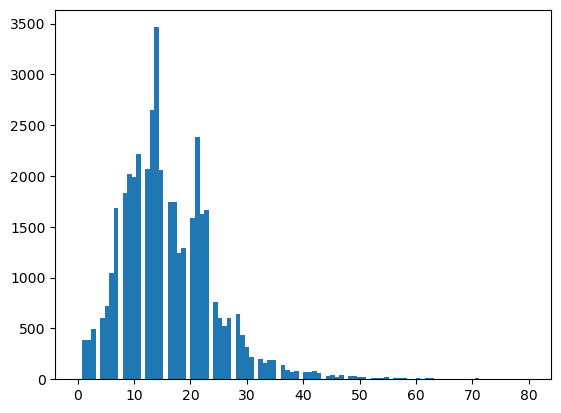

In [86]:
from matplotlib import pyplot as plt
plt.hist(df["los"], bins=100, range=(0, 80))
# plt.hist(df["ptindweek2"])
# plt.hist(df["ptindweek1"])

In [87]:
# similar summary for categorical features

categorical_summary_list = []

for name in categorical_feature_set:
    if name in df.columns:
        total_count = len(df)
        unique_values = df[name].nunique()
        # print(name, df[name].unique())
        print(f"Feature: {name}")
        value_counts = df[name].value_counts()
        for value, count in value_counts.items():
            print(f"  {value}: {count}")
        mode_value = df[name].mode()[0] if not df[name].mode().empty else None
        mode_count = df[name].value_counts().get(mode_value, 0)
        mode_ratio = mode_count / total_count if total_count > 0 else None
        unknown_count = df[name].eq("Unknown").sum()
        missing_rate = unknown_count / total_count

        categorical_summary_list.append({
            "name": name,
            "unique_values": unique_values,
            "mode": mode_value,
            "mode_ratio": mode_ratio,
            "unknown_ratio": missing_rate,
        })

categorical_summary = pd.DataFrame(categorical_summary_list).set_index("name")
categorical_summary.index.name = None

print(tabulate(categorical_summary.map(lambda x: f"{x:.4f}" if isinstance(x, float) else x), headers='keys'))

markdown_output = categorical_summary.to_markdown(floatfmt=".2f", tablefmt="pipe")
print(markdown_output)

Feature: sex
  male: 22713
  female: 20225
Feature: pain_activities_adm
  No: 17617
  Unknown: 15348
  Yes: 9973
Feature: marital_status
  Unmarried: 20703
  Married: 19766
  Unknown: 2469
Feature: socisolation_adm
  No: 34634
  Yes: 4166
  Unknown: 4138
Feature: hispanic
  No: 39745
  Yes: 3193
Feature: low_interest_adm
  0: 33620
  1: 4741
  Unknown: 4577
Feature: falls_hx
  No: 26714
  Yes: 13847
  Unknown: 2377
Feature: pain_therapy_adm
  No: 20834
  Unknown: 15296
  Yes: 6808
Feature: payor_primary
  Medicare_FFS: 16063
  Not_listed: 14576
  Medicare_Advantage: 12299
Feature: health_lit_adm
  No: 25826
  Yes: 13659
  Unknown: 3453
Feature: bims_total
  Intact: 23035
  Moderate: 10345
  Severe: 4900
  Unable_to_complete: 4658
Feature: stroke_type
  Ischemic: 35805
  Hemorrhagic: 6486
  Other: 647
Feature: hearing_adm
  Not_impaired: 39733
  Impaired: 3205
Feature: depressed_adm
  0: 31768
  1: 6529
  Unknown: 4641
Feature: vision_adm
  Not_impaired: 39065
  Impaired: 3873
Feature: 

Filter out some features based on extreme statistics:
1. numeric features with a na_ratio > 0.3
2. numeric features with a std < 0.1
3. categorical features with a mode_ratio > 0.95

In [88]:
# safe buffer
last_df = df

In [89]:
# drop some features with extreme statistics
df = last_df.copy()

numeric_exclude = stats[
    (stats["na_ratio"] > 0.3) | (stats["std"] < 0.1)
].index.tolist()

categorical_exclude = categorical_summary[
    categorical_summary["mode_ratio"] > 0.95
].index.tolist()

features_to_exclude = numeric_exclude + categorical_exclude

df = df.drop(columns=features_to_exclude)

print("Feature table after dropping some statistically extreme features:")
print(tabulate_df(df))

Feature table after dropping some statistically extreme features:
+---------+------------------------+---------+-------------+
|   Index | Name                   | Dtype   |   # of NaNs |
+=========+========================+=========+=============+
|       0 | selfcare_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       1 | mobility_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       2 | selfcare_measure_dc    | float64 |           0 |
+---------+------------------------+---------+-------------+
|       3 | mobility_measure_dc    | float64 |           0 |
+---------+------------------------+---------+-------------+
|       4 | sex                    | object  |           0 |
+---------+------------------------+---------+-------------+
|       5 | marital_status         | object  |           0 |
+---------+------------------------+---------+-------------+
|       6 | payor_p

In [90]:
# save
df.to_csv('./data/Cleaned files/Cogan_2_2.csv', index=True)

# save interested predictors and outcomes
selected_feature_dict = {
    "predictors": interested_predictors,
    "outcomes": interested_outcomes,
    "therapy_predictors": therapy_predictors,
}
with open('./data/Cleaned files/selected_features.json', 'w') as json_file:
    json.dump(selected_feature_dict, json_file)

### 2.3 One-hot expansion

In [91]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_2.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]
# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 50
+---------+------------------------+---------+-------------+
|   Index | Name                   | Dtype   |   # of NaNs |
+=========+========================+=========+=============+
|       0 | selfcare_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       1 | mobility_measure_delta | float64 |           0 |
+---------+------------------------+---------+-------------+
|       2 | selfcare_measure_dc    | float64 |           0 |
+---------+------------------------+---------+-------------+
|       3 | mobility_measure_dc    | float64 |           0 |
+---------+------------------------+---------+--------

In [92]:
# safe buffer
last_df = df

In [93]:
# expand all categorical features to n_class-1 one-hot representations
df = last_df.copy()

columns_to_one_hot = []
for name in df.columns:
    if name in categorical_feature_set:
        columns_to_one_hot.append(name)
df = pd.get_dummies(df, columns=columns_to_one_hot, drop_first=True)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns}) # 0/1 instead of False/True

print(tabulate_df(df))

+---------+------------------------------------------------+---------+-------------+
|   Index | Name                                           | Dtype   |   # of NaNs |
+=========+================================================+=========+=============+
|       0 | selfcare_measure_delta                         | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       1 | mobility_measure_delta                         | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       2 | selfcare_measure_dc                            | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       3 | mobility_measure_dc                            | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       4 | ptindweek1                                     | floa

In [94]:
# get categorical column names after expansion

one_hot_encoded_columns = set(df.columns) - set(last_df.columns)
print(one_hot_encoded_columns)

{'health_lit_adm_Yes', 'bims_total_Moderate', 'race_Black_or_African_American', 'payor_primary_Not_listed', 'sex_male', 'stroke_type_Ischemic', 'depressed_adm_Unknown', 'falls_hx_Yes', 'pain_sleep_adm_Yes', 'falls_hx_Unknown', 'race_White', 'vision_adm_Not_impaired', 'race_Multiracial', 'pain_sleep_adm_Unknown', 'hispanic_Yes', 'pain_therapy_adm_Unknown', 'socisolation_adm_Unknown', 'bladder_incontinence_Unknown', 'marital_status_Unmarried', 'race_Native_Hawaiian_or_Other_Pacific_Islander', 'bowel_incontinence_Unknown', 'pain_therapy_adm_Yes', 'race_Unknown', 'socisolation_adm_Yes', 'race_Asian', 'pain_activities_adm_Yes', 'bladder_incontinence_Incontinent', 'marital_status_Unknown', 'stroke_type_Other', 'bims_total_Severe', 'bims_total_Unable_to_complete', 'health_lit_adm_Unknown', 'payor_primary_Medicare_FFS', 'depressed_adm_1', 'hearing_adm_Not_impaired', 'bowel_incontinence_Incontinent', 'pain_activities_adm_Unknown', 'low_interest_adm_1', 'low_interest_adm_Unknown'}


In [95]:
# update feature table

feature_table['categorical_after_onehot'] = one_hot_encoded_columns
print(feature_table.keys())
with open("./data/Cleaned files/feature_table.pkl", 'wb') as f:
    pickle.dump(feature_table, f)

dict_keys(['categorical', 'numeric', 'ranked_int', 'binary', 'categorical_after_onehot'])


In [96]:
# save new dataframe csv

df.to_csv('./data/Cleaned files/Cogan_2_3.csv', index=True)

### 2.4 Imputation


In [97]:
IMPUTATION_STRATEGY = ['default', 'mice'][1]

# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_3.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
# convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical"]
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']



# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 70
+---------+------------------------------------------------+---------+-------------+
|   Index | Name                                           | Dtype   |   # of NaNs |
+=========+================================================+=========+=============+
|       0 | selfcare_measure_delta                         | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       1 | mobility_measure_delta                         | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       2 | selfcare_measure_dc                            | float64 

#### 2.3.a Default Strategy (Legacy)

In [98]:
# safe buffer
last_df = df

In [99]:
# ranked int: mode imputation; numeric: mean imputation
if IMPUTATION_STRATEGY == 'default':
    df = last_df.copy() # always work on a fresh copy of last step's output

    print("# of nans before:", df.isna().sum().sum())

    train_indices = split_dict['train']

    train_df = df.loc[train_indices]

    for name in df.columns:
        if name in ranked_int_feature_set:
            mode_value = train_df[name].mode()[0]  # get the most frequent value in the training set
            df[name].fillna(mode_value, inplace=True)
        elif name in numeric_feature_set:
            mean_value = train_df[name].mean()
            df[name].fillna(mean_value, inplace=True)
            df[name] = df[name].round(2)

    print("# of nans left:", df.isna().sum().sum())


#### 2.3.b MICE

In [100]:
# safe buffer
last_df = df

In [101]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
if IMPUTATION_STRATEGY == 'mice':
    df = last_df.copy() # always work on a fresh copy of last step's output

    # exlcude outcome columns when training imputer
    outcome_columns = df[interested_outcomes]
    df_no_outcomes = df.drop(columns=interested_outcomes)
    print("# of nans before:", df_no_outcomes.isna().sum().sum())

    train_indices = split_dict['train']
    train_df = df_no_outcomes.loc[train_indices]

    print(train_df)
    imputer = IterativeImputer(initial_strategy="mean", max_iter=50, random_state=42, verbose=2)

    imputer.fit(train_df)
    # when doing imputation, imputer cant see outcomes as well, put outcomes back later
    imputed_data = imputer.transform(df_no_outcomes)

    imputed_df = pd.DataFrame(imputed_data, columns=df_no_outcomes.columns, index=df.index)

    # dtype int for ranked integers
    for name in imputed_df.columns:
        if name in ranked_int_feature_set:
            imputed_df[name] = imputed_df[name].round().astype(int)

    # put outcomes back
    imputed_df[interested_outcomes] = outcome_columns

    df = imputed_df
    print("# of nans left:", df.isna().sum().sum())



# of nans before: 897
       ptindweek1  otindweek1  slpindweek1  ptindweek2  otindweek2  \
id                                                                   
16177       300.0       300.0        300.0        60.0        60.0   
33741       441.0       231.0        229.0       315.0       348.0   
17276       405.0       318.0         90.0       180.0       136.0   
24974       300.0       315.0        300.0        60.0        60.0   
30536       325.0       390.0        320.0       310.0       340.0   
...           ...         ...          ...         ...         ...   
24902       345.0       465.0        271.0        60.0       300.0   
41679       230.0       416.0        292.0       311.0       509.0   
43257       543.0       391.0        167.0       518.0       428.0   
12210       395.0       240.0        240.0       395.0       450.0   
39274       515.0       463.0         16.0       470.0       545.0   

       slpindweek2  ptindweek1+2  otindweek1+2  slpindweek1+2  ptin

#### Save

In [102]:
# save df

df.to_csv('./data/Cleaned files/Cogan_2_4.csv', index=True)

### 2.5 Normalization

In [103]:
# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

def convert_dtypes(df, dtype_dict):
    for name in df.columns:
        dtype = dtype_dict[name]
        df[name] = df[name].astype(dtype)

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_4.csv', low_memory=False, index_col='id')
with open("./data/Cleaned files/lookup_table.pkl", 'rb') as f:
    lookup_table = pickle.load(f)
with open("./data/Cleaned files/feature_table.pkl", 'rb') as f:
    feature_table = pickle.load(f)

# convert dtypes
with open('./data/Cleaned files/processed_feature_dtypes.json', 'r') as f:
    dtype_dict = json.load(f)
# convert_dtypes(df, dtype_dict)

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))
categorical_feature_set = feature_table["categorical_after_onehot"] # read the new categorical column names after onehot expansion
numeric_feature_set = feature_table["numeric"]
ranked_int_feature_set = feature_table["ranked_int"]
binary_feature_set = feature_table["binary"]

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
interested_predictors = selected_feature_dict['predictors']
interested_outcomes = selected_feature_dict['outcomes']
therapy_predictors = selected_feature_dict['therapy_predictors']


# of train samples: 28625
# of eval samples: 7156
# of test samples: 7157
# of valid selfcare train samples: 28625
# of valid selfcare eval samples: 7156
# of valid selfcare test samples: 7157
# of valid mobility train samples: 28625
# of valid mobility eval samples: 7156
# of valid mobility test samples: 7157
total # of features: 70
+---------+------------------------------------------------+---------+-------------+
|   Index | Name                                           | Dtype   |   # of NaNs |
+=========+================================================+=========+=============+
|       0 | ptindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       1 | otindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       2 | slpindweek1                                    | float64 

In [104]:
# safe buffer
last_df = df

In [105]:
import pandas as pd
import json

df = last_df.copy() # always work on a fresh copy of last step's output

# Step 1: Identify columns that need to be standardized
columns_to_standardize = [
    col for col in interested_predictors 
    if col in df.columns and col not in categorical_feature_set and col not in binary_feature_set
]

# Step 2: Initialize a dictionary to store means and standard deviations
scaling_params = {}

# Step 3: Standardize the selected columns
for col in columns_to_standardize:
    mean = df[col].mean()
    std = df[col].std()
    
    # Store mean and std for later use
    scaling_params[col] = {'mean': mean, 'std': std}
    
    # Apply standardization to the column
    df[col] = (df[col] - mean) / std

# Step 4: Save the scaling parameters to a JSON file
with open('./data/Cleaned files/standardization_params.json', 'w') as f:
    json.dump(scaling_params, f)

# Step 5: Verify the standardization
print(f"Standardized columns: {columns_to_standardize}")
print(f"Total standardized columns: {len(columns_to_standardize)}")
print("Saved scaling parameters to './data/Cleaned files/standardization_params.json'")


Standardized columns: ['ptindweek1', 'otindweek1', 'slpindweek1', 'ptindweek2', 'otindweek2', 'slpindweek2', 'ptindweek1+2', 'otindweek1+2', 'slpindweek1+2', 'ptindperday', 'otindperday', 'slpindperday', 'ptindextrap', 'otindextrap', 'slpindextrap', 'expression_adm', 'understand_verbal_adm', 'selfcare_prior', 'mobility_prior', 'selfcare_measure_adm', 'mobility_measure_adm', 'age_at_admit', 'los']
Total standardized columns: 23
Saved scaling parameters to './data/Cleaned files/standardization_params.json'


In [106]:
# save df

df.to_csv('./data/Cleaned files/Cogan_2_5.csv', index=True)